<a href="https://colab.research.google.com/github/R12942159/DeepLearning/blob/main/DLCV_hw1_EFFICIENTNET_V2_M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch


# Get cuda from GPU device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cpu


In [12]:
import os


# search file paths
def img_paths(path):
  paths = [i for i in os.listdir(path) if i.endswith('.png')]
  return paths

img_paths_train = img_paths('/content/drive/MyDrive/NTU_DLCV/p1_data/train_50')
img_paths_val = img_paths('/content/drive/MyDrive/NTU_DLCV/p1_data/val_50')

In [18]:
# number of images
len(img_paths_train), len(img_paths_val)

(22500, 2500)

In [19]:
import torch
from PIL import Image
import numpy as np


class PretrainDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = Image.open(path).convert('RGB') # read img

        # transform img
        img = self.transform(img)

        # Read class index
        cls_idx = int((path.split('/')[-1]).split('_')[0])
        cls_idx = torch.tensor(cls_idx, dtype=torch.int64)

        return img, cls_idx

In [20]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights


# Preprocess Transform
transform =  EfficientNet_B4_Weights.DEFAULT.transforms()

# Build Dataset
train_ds = PretrainDataset(img_paths_train, transform)
val_ds = PretrainDataset(img_paths_val, transform)

In [21]:
transform

ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
# Build DataLoaders
BATCH_SIZE = 50
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#### Build Model (https://pytorch.org/vision/stable/models.html#classification)

In [ ]:
from torchvision import models

model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
print(model)

In [23]:
# 获取最后一层线性层的子模块列表
last_layer = list(model.children())[-1]

# 获取线性层中的权重和偏差
weights = last_layer[1].weight
bias = last_layer[1].bias

# 创建一个新的线性层，将out_features设置为50
new_linear_layer = torch.nn.Linear(in_features=weights.shape[1], out_features=50, bias=True)

# 将新的线性层的权重和偏差设置为旧线性层的权重和偏差
new_linear_layer.weight.data = weights
new_linear_layer.bias.data = bias

# 将新的线性层替换为模型的最后一层
last_layer[1] = new_linear_layer

In [24]:
from torchsummary import summary


resize_size = transform.resize_size[0]
summary(model.to(device), (3, resize_size, resize_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 192, 192]           1,296
       BatchNorm2d-2         [-1, 48, 192, 192]              96
              SiLU-3         [-1, 48, 192, 192]               0
            Conv2d-4         [-1, 48, 192, 192]             432
       BatchNorm2d-5         [-1, 48, 192, 192]              96
              SiLU-6         [-1, 48, 192, 192]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 192, 192]               0
           Conv2d-13         [-1, 24, 192, 192]           1,152
      BatchNorm2d-14         [-1, 24, 1

#### Train Model

In [25]:
from tqdm.auto import tqdm # (optional) progress bar


def training(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode. (The Dropout layer has a different behavior between the training mode and the evaluation mode.)
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def testing(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [ ]:
import matplotlib.pyplot as plt
from torch import nn
import numpy as np


def train(pretrained=True, freeze=False):
    print(f"pretrained weights: {pretrained}, freeze: {freeze}")
    # Model
    if pretrained:
        model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    else:
        model = models.efficientnet_b4(weights=None)

    if freeze:
        # Freeze model
        for param in model.parameters():
            param.requires_grad = False

    # Replace classifier
    last_layer = list(model.children())[-1]
    weights = last_layer[1].weight
    bias = last_layer[1].bias
    new_linear_layer = torch.nn.Linear(in_features=weights.shape[1], out_features=50, bias=True)
    new_linear_layer.weight.data = weights
    new_linear_layer.bias.data = bias
    last_layer[1] = new_linear_layer

    model = model.to(device)

    # set the loss func.
    loss_fn = nn.CrossEntropyLoss()
    # lower learning rate for finetuning
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=1e-4)


    EPOCHS = 15
    logs = {
        'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
    }
    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_acc = training(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = testing(val_loader, model, loss_fn)

        # # Note that step should be called after test_epoch()
        # schedule.step(val_loss)

        print(f'EPOCH: {epoch:04d} \
        train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
        val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

        logs['train_loss'].append(train_loss)
        logs['train_acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)


    # plot result
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(logs['train_loss'])
    plt.plot(logs['val_loss'])
    plt.subplot(1, 2, 2)
    plt.title('Acc.')
    plt.plot(logs['train_acc'])
    plt.plot(logs['val_acc'])
    plt.show()

    # Save model
    torch.save(model.state_dict(), "last.pth")

#### Transfer Learning

pretrained weights: True, freeze: False


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0000         train_loss: 3.5765, train_acc: 0.207         val_loss: 1.3783, val_acc: 0.626 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0001         train_loss: 1.1548, train_acc: 0.673         val_loss: 0.6629, val_acc: 0.806 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0002         train_loss: 0.6597, train_acc: 0.805         val_loss: 0.5309, val_acc: 0.835 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0003         train_loss: 0.4594, train_acc: 0.858         val_loss: 0.4593, val_acc: 0.857 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0004         train_loss: 0.3444, train_acc: 0.892         val_loss: 0.4440, val_acc: 0.868 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0005         train_loss: 0.2615, train_acc: 0.915         val_loss: 0.4455, val_acc: 0.874 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0006         train_loss: 0.2042, train_acc: 0.935         val_loss: 0.4445, val_acc: 0.876 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0007         train_loss: 0.1640, train_acc: 0.948         val_loss: 0.4535, val_acc: 0.878 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0008         train_loss: 0.1293, train_acc: 0.958         val_loss: 0.4741, val_acc: 0.878 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0009         train_loss: 0.1064, train_acc: 0.967         val_loss: 0.4873, val_acc: 0.878 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0010         train_loss: 0.0923, train_acc: 0.970         val_loss: 0.4708, val_acc: 0.884 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0011         train_loss: 0.0738, train_acc: 0.976         val_loss: 0.5010, val_acc: 0.887 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0012         train_loss: 0.0619, train_acc: 0.980         val_loss: 0.5010, val_acc: 0.886 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0013         train_loss: 0.0563, train_acc: 0.982         val_loss: 0.5096, val_acc: 0.880 


  0%|          | 0/450 [00:00<?, ?it/s]

EPOCH: 0014         train_loss: 0.0507, train_acc: 0.984         val_loss: 0.5241, val_acc: 0.888 


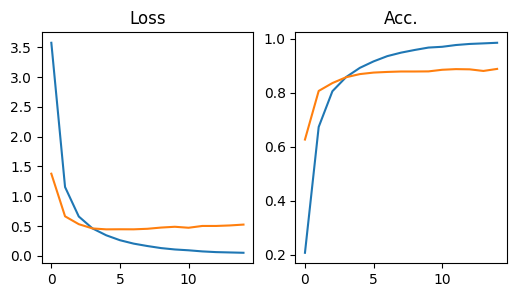

In [ ]:
train()